## Lab3 Part 2

Lab3 is splitted into two parts as it is getting really long.
## Task 5.1 Dynamic Programming
The goal of this second half of the lab is to investigate dynamic progamming along scanlines in stereo vision.  In this part of the practical, we build a basic dynamic programming algorithm, which will solve the same problem as presented in the notes.  

In Task5 we will apply this to the stereo problem.  

Use the template below, filling in parts marked "TO DO" (only todo for Task 5.1 one is in functions.py).



In [127]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from functions import dynamicProgram, dynamicProgramVec
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
# Defining the unary and pairwise costs for the dynamic programming algorithm for 6 pixels and 5 disparity levels.

# Define unary costs unaryCosts[d,j] 
# represents the cost for having disparity d (rows) at pixel j (columns).
unaryCosts = np.array([ [2.0, 1.1, 5.7, 1.5, 6.0, 3.1],
                        [0.8, 4.8, 1.0, 3.0, 6.9, 3.3],
                        [4.3, 2.3, 2.4, 2.4, 6.6, 6.2],
                        [6.4, 0.0, 6.1, 0.8, 7.1, 2.1],
                        [2.3, 2.2, 4.9, 8.9, 1.0, 9.8]])
nY = len(unaryCosts) # Number of pixels
nX = len(unaryCosts[0]) # Number of disparity levels

# Define pairwise costs:  pairwiseCosts[a,b] 
# represents the cost for changing from disparity level a to disparity level b.
# The matrix is symmetric, i.e., pairwiseCosts[a,b] = pairwiseCosts[b,a]
# suggesting that the cost of changing from a to b is the same as from b to a.
pairwiseCosts = np.array([[   0,   2, 100, 100, 100],
                          [   2,   0,   2, 100, 100],
                          [ 100,   2,   0,   2, 100],
                          [ 100, 100,   2,   0,   2],
                          [ 100, 100, 100,   2,   0]])


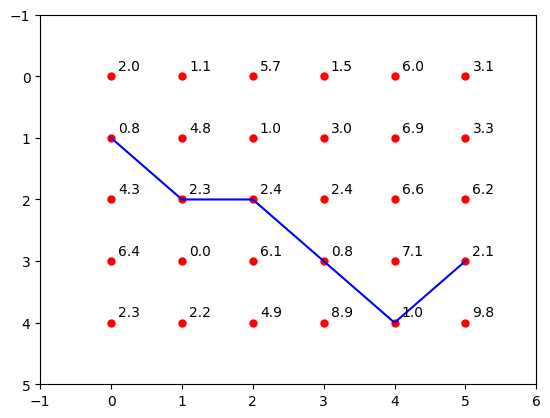

Path Cost = 17.4


In [130]:
## Use the dynamic programming algorithm to find the best path
bestPath = dynamicProgram(unaryCosts,pairwiseCosts)

## Calculate the cost of the best path: equal to the sum of unary and pairwise costs along the best path
# Sum of unary costs along the best path
bestPathCostUnary = np.sum((np.transpose(unaryCosts).reshape((nX*nY,1)))[(np.add(nY * np.array(range(nX)),np.transpose(bestPath)[0])).astype(int)])
# Sum of pairwise costs along the best path
bestPathCostPairwise = np.sum(np.transpose(pairwiseCosts).reshape((nY*nY,1))[np.array([bestPath[0:-1]+nY*bestPath[1:]]).reshape((1,nY)).astype(int)[0]])
# Total cost
bestCost = bestPathCostUnary+bestPathCostPairwise
# Display the cost of the best path


## Display the best path results
plt.figure()
plt.axis([-1, 6, 5, -1]) # Note that the y axis was reversed to match the matrix elements
for cY in range(nY):
    for cX in range(nX):
        plt.plot(cX,cY,'ro',ms=5.)
        plt.text(cX+.1, cY-.1, unaryCosts[cY,cX])

# Display the best path
plt.plot(range(nX),bestPath,'b-')
plt.show()
print('Path Cost =',bestCost)

## Task 5.2 Dynamic Programming for stereo depth estimation


The goal of this part of the practical is to use the dynamic programming routine that you developed in the first part to solve the dense stereo problem.

Use the template below, filling in parts marked "TO DO".

### Extra Tasks:
Task hint: Crop or downsample your image if your stereo is slow

Task1: Capture or find two image pairs: one with good stereo depth and one with bad stereo depth. Note that you should only the two camera have a known, and there should be no moving objects in the scene.

Task2: Measure your baseline distance between the camera with a ruler, does the depth esimation match the real distance？

Task3: (Unmarked Optional) Can you use two cameras at the same time for stereo capture?

In [131]:
%load_ext autoreload
%autoreload 2

import numpy as np 
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
from functions import dynamicProgram, dynamicProgramVec
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
# load in images and ground truth
data = loadmat('../dataset/StereoData.mat')
im1 = data['im1'].astype('int') 
im2 = data['im2'].astype('int')
gt = data['gt'].astype('int')



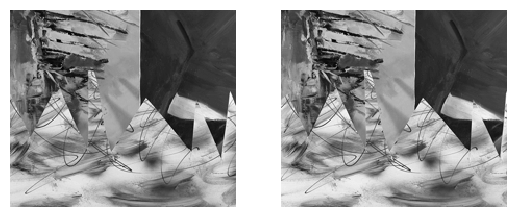

In [147]:
# Ground truth disparity is originally expressed in 16'ths of pixels 
# but we will only consider whole-pixel shifts
gtDisp = np.round(gt.astype(float)/16)
# Normalise images for display [0-255] --> [0-1]
im1show = im1 
im2show = im2 
if np.max(im1) > 1:
    im1show = im1.astype(float)/255. 
    im2show = im2.astype(float)/255.

# Plot images and ground truth disparity
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im1show, cmap='gray', interpolation='nearest', aspect=1)
ax1.axis('off')
ax2.imshow(im2show, cmap='gray', interpolation='nearest', aspect=1)
ax2.axis('off')
plt.show()

### Complete the TODOs in the final cell below

Here we are going to make use of the "dynamicProgram" function we just wrote.

We will first calculate the unary costs before using our function to calculate estimated disparity.

Procesing scanline  189
Max Disp: 10
imX - maxDisp: 207


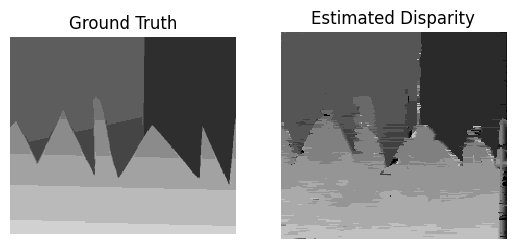

In [137]:
# Shape of the images
imY = im1.shape[0] # Rows in the image
imX = im1.shape[1] # Columns in the image

# Define the maximum disparity to consider
maxDisp = 10

# Define standard deviation of noise
noiseSD = 6 # standard deviation of noise

# Define the pairwise costs
# Zero cost for staying the same (diagonal elements) and fixed cost alpha for changing disparity (elsewhere)
alpha = 1
pairwiseCosts = alpha * (np.ones([maxDisp,maxDisp]) - np.eye(maxDisp))

# Initialise the estimated disparity map

estDisp = np.zeros([imY,imX-maxDisp]) 

# Run through each scanline
for cY in range(imY):
    
    # Define unary costs 
    # we will not use the last few columns of the image 
    # as the disparity might map the pixel outside the valid area of the second image
    unaryCosts = np.zeros([maxDisp,imX-maxDisp])

    for cDisp in range(maxDisp):
        cost=np.zeros(imX-maxDisp) # Cost for this disparity level

        for cX in range(imX-maxDisp):
            # Ensure valid bounds for slices
            im1_slice = im1[cY, cX:cX+maxDisp]
            im2_slice = im2[cY, cX+cDisp:min(cX+maxDisp+cDisp, imX)] # Ensure we don't go out of bounds
            
            # Pad im2_slice if it's smaller than maxDisp
            if len(im2_slice) < maxDisp:
                im2_slice = np.pad(im2_slice, (0, maxDisp - len(im2_slice)), mode='constant', constant_values=0)
            
            # Calculate the difference between the two slices
            diff = im1_slice - im2_slice
            diff2 = np.square(diff)
            
            # Calculate the cost
            cost[cX] = np.sum(diff2) / (2 * noiseSD**2)
            
        
        # Store the cost in the unaryCosts matrix as a row
        unaryCosts[cDisp,:] = cost

            
    # Run dynamic programming algorithm to find the best path for each scanline
    estDisp[cY,:] = np.transpose(dynamicProgram(unaryCosts,pairwiseCosts))

print('Procesing scanline ',cY)
print(f'Max Disp: {maxDisp}')
print(f'imX - maxDisp: {imX-maxDisp}')
# display solution so far
f, (ax1, ax2) = plt.subplots(1, 2)
#ax1.clear()
ax1.imshow(gtDisp, vmin=0,vmax=11, cmap='gray', extent=[0,len(gtDisp[0]),0,len(gtDisp)],interpolation='nearest')
ax1.axis('off')
ax1.set_title('Ground Truth')
#ax2.clear()
ax2.imshow(estDisp, vmin=0,vmax=12, cmap='gray', extent=[0,len(estDisp[0]),0,len(estDisp)],interpolation='nearest')
ax2.axis('off')
ax2.set_title('Estimated Disparity')
plt.show()
    

Procesing scanline  189
Max Disp: 10
imX - maxDisp: 207


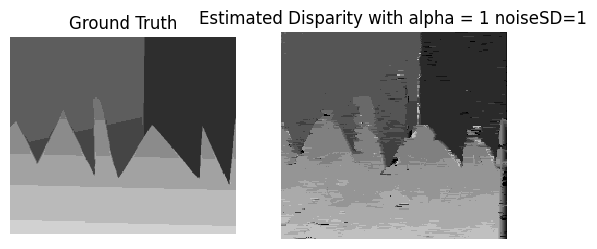

Procesing scanline  189
Max Disp: 10
imX - maxDisp: 207


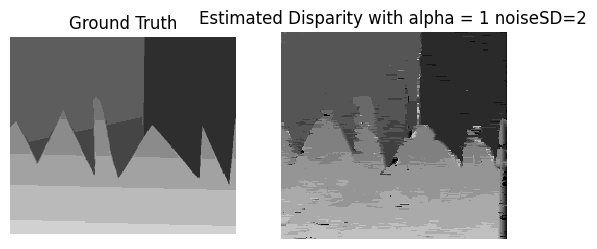

Procesing scanline  189
Max Disp: 10
imX - maxDisp: 207


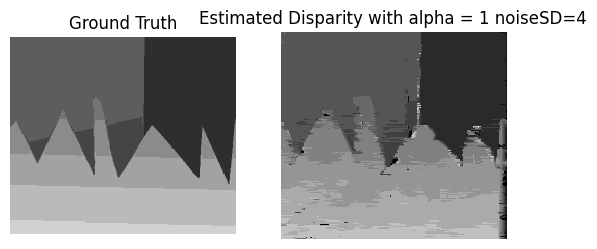

Procesing scanline  189
Max Disp: 10
imX - maxDisp: 207


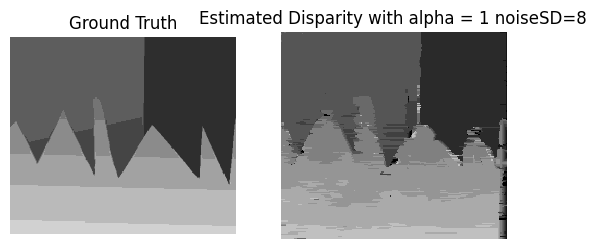

Procesing scanline  189
Max Disp: 10
imX - maxDisp: 207


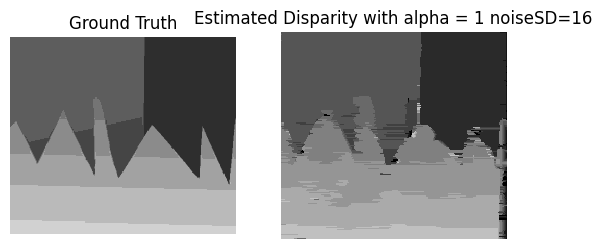

Procesing scanline  189
Max Disp: 10
imX - maxDisp: 207


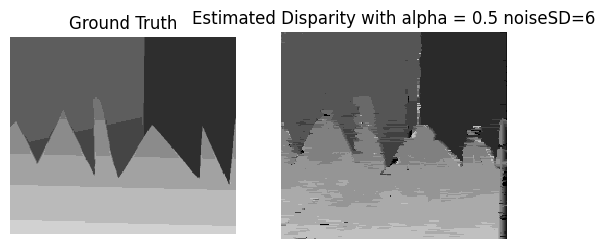

Procesing scanline  189
Max Disp: 10
imX - maxDisp: 207


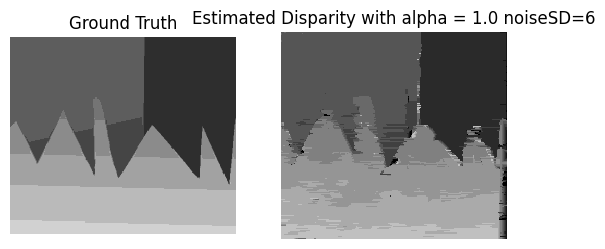

Procesing scanline  189
Max Disp: 10
imX - maxDisp: 207


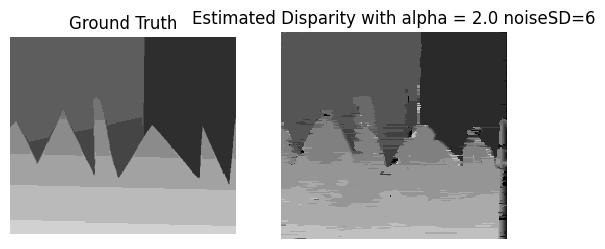

Procesing scanline  189
Max Disp: 10
imX - maxDisp: 207


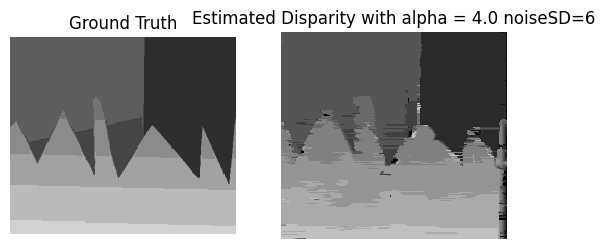

In [ ]:
# TODO - investigate how different values of alpha and noiseSD affect the results
maxDisp = 10
noiseSD_array = np.array([1, 2, 4, 8, 16]) # standard deviation of noise
alpha_array= np.array([0.5, 1, 2, 4]) # alpha

imY = im1.shape[0] # Rows in the image
imX = im1.shape[1] # Columns in the image


# Set alpha to 1 and iterate through noiseSD
alpha = 1
pairwiseCosts = alpha * (np.ones([maxDisp,maxDisp]) - np.eye(maxDisp))
estDisp = np.zeros([imY,imX-maxDisp]) 
for noiseSD in noiseSD_array:
    # Run through each scanline
    for cY in range(imY):
        
        # Define unary costs 
        # we will not use the last few columns of the image 
        # as the disparity might map the pixel outside the valid area of the second image
        unaryCosts = np.zeros([maxDisp,imX-maxDisp])

        for cDisp in range(maxDisp):
            cost=np.zeros(imX-maxDisp) # Cost for this disparity level

            for cX in range(imX-maxDisp):
                # Ensure valid bounds for slices
                im1_slice = im1[cY, cX:cX+maxDisp]
                im2_slice = im2[cY, cX+cDisp:min(cX+maxDisp+cDisp, imX)] # Ensure we don't go out of bounds
                
                # Pad im2_slice if it's smaller than maxDisp
                if len(im2_slice) < maxDisp:
                    im2_slice = np.pad(im2_slice, (0, maxDisp - len(im2_slice)), mode='constant', constant_values=0)
                
                # Calculate the difference between the two slices
                diff = im1_slice - im2_slice
                diff2 = np.square(diff)
                
                # Calculate the cost
                cost[cX] = np.sum(diff2) / (2 * noiseSD**2)
                
            
            # Store the cost in the unaryCosts matrix as a row
            unaryCosts[cDisp,:] = cost

                
        # Run dynamic programming algorithm to find the best path for each scanline
        estDisp[cY,:] = np.transpose(dynamicProgramVec(unaryCosts,pairwiseCosts))

    print('Procesing scanline ',cY)
    print(f'Max Disp: {maxDisp}')
    print(f'imX - maxDisp: {imX-maxDisp}')
    # display solution so far
    f, (ax1, ax2) = plt.subplots(1, 2)
    #ax1.clear()
    ax1.imshow(gtDisp, vmin=0,vmax=11, cmap='gray', extent=[0,len(gtDisp[0]),0,len(gtDisp)],interpolation='nearest')
    ax1.axis('off')
    ax1.set_title('Ground Truth')
    #ax2.clear()
    ax2.imshow(estDisp, vmin=0,vmax=12, cmap='gray', extent=[0,len(estDisp[0]),0,len(estDisp)],interpolation='nearest')
    ax2.axis('off')
    ax2.set_title(f'Estimated Disparity with alpha = {alpha} noiseSD={noiseSD}')
    # Save figure
    figName = f'../results/lab3/EstimatedDisparity_alpha{alpha}_noiseSD{noiseSD}.png'
    plt.savefig(figName)
    plt.show()

# Set noiseSD to 6 and iterate through alpha
noiseSD = 6
for alpha in alpha_array:
    pairwiseCosts = alpha * (np.ones([maxDisp,maxDisp]) - np.eye(maxDisp))
    estDisp = np.zeros([imY,imX-maxDisp]) 
    for cY in range(imY):
        
        # Define unary costs 
        # we will not use the last few columns of the image 
        # as the disparity might map the pixel outside the valid area of the second image
        unaryCosts = np.zeros([maxDisp,imX-maxDisp])

        for cDisp in range(maxDisp):
            cost=np.zeros(imX-maxDisp) # Cost for this disparity level

            for cX in range(imX-maxDisp):
                # Ensure valid bounds for slices
                im1_slice = im1[cY, cX:cX+maxDisp]
                im2_slice = im2[cY, cX+cDisp:min(cX+maxDisp+cDisp, imX)] # Ensure we don't go out of bounds
                
                # Pad im2_slice if it's smaller than maxDisp
                if len(im2_slice) < maxDisp:
                    im2_slice = np.pad(im2_slice, (0, maxDisp - len(im2_slice)), mode='constant', constant_values=0)
                
                # Calculate the difference between the two slices
                diff = im1_slice - im2_slice
                diff2 = np.square(diff)
                
                # Calculate the cost
                cost[cX] = np.sum(diff2) / (2 * noiseSD**2)
                
            
            # Store the cost in the unaryCosts matrix as a row
            unaryCosts[cDisp,:] = cost

                
        # Run dynamic programming algorithm to find the best path for each scanline
        estDisp[cY,:] = np.transpose(dynamicProgramVec(unaryCosts,pairwiseCosts))

    print('Procesing scanline ',cY)
    print(f'Max Disp: {maxDisp}')
    print(f'imX - maxDisp: {imX-maxDisp}')
    # display solution so far
    f, (ax1, ax2) = plt.subplots(1, 2)
    #ax1.clear()
    ax1.imshow(gtDisp, vmin=0,vmax=11, cmap='gray', extent=[0,len(gtDisp[0]),0,len(gtDisp)],interpolation='nearest')
    ax1.axis('off')
    ax1.set_title('Ground Truth')
    #ax2.clear()
    ax2.imshow(estDisp, vmin=0,vmax=12, cmap='gray', extent=[0,len(estDisp[0]),0,len(estDisp)],interpolation='nearest')
    ax2.axis('off')
    ax2.set_title(f'Estimated Disparity with alpha = {alpha} noiseSD={noiseSD}')
    # Save figure
    figName = f'../results/lab3/EstimatedDisparity_alpha{alpha}_noiseSD{noiseSD}.png'
    plt.savefig(figName)
    plt.show()
    

In [ ]:

# TODO (optional) 
# rewrite the the "dynamicProgram" in the "dynamicProgramVec" function to make it more efficient. 
# Check the improvements by timining the function calls.

# TODO (optional) 
# you should be able to rewrite this (calculating unary costs) with fewer loops once you have
# the general idea so that it runs faster. Again you can check the speed improvements by timing them.

# TODO (optional)- adapt the algorithm so that it makes use of colour information in the images